In [1]:
import os
import tifffile 
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook as tqdm
from shutil import copyfile
import numpy as np

In [2]:
working_dir = '/media/jswaney/SSD EVO 860/organoid_phenotyping/ventricle_segmentation'

In [3]:
def load_tiff_bioformats(path):
    data = tifffile.imread(path)[0, 0]  # Bioformats 5D stack
    return data[0], data[1]

# Normalize and make train and test sets

In [4]:
data_dir = 'data_pz'  # combined from organoids available

files = os.listdir(os.path.join(working_dir, data_dir))
len(files)

607

In [5]:
max_value = 0
min_value = 1e6
for file in tqdm(files):
    img, seg = load_tiff_bioformats(os.path.join(working_dir, 
                                                 data_dir,
                                                 file))
    current_min, current_max = img.min(), img.max()
    if current_max > max_value:
        max_value = current_max
    if current_min < min_value:
        min_value = current_min
print(min_value, max_value)


0.0 1.0


In [6]:
files_train, files_test = train_test_split(files, 
                                           test_size=0.20, 
                                           random_state=123)
len(files_train), len(files_test)

(485, 122)

In [8]:
train_dir = 'train_pz'
test_dir = 'test_pz'
class_dir = 'class_0'

os.makedirs(os.path.join(working_dir, train_dir, class_dir), 
            exist_ok=True)
os.makedirs(os.path.join(working_dir, test_dir, class_dir), 
            exist_ok=True)

for file in tqdm(files_train):
    input_path = os.path.join(working_dir, data_dir, file)
    output_path = os.path.join(working_dir, train_dir, class_dir, file)
    img, seg = load_tiff_bioformats(os.path.join(working_dir, 
                                                 data_dir,
                                                 file))
    img_normalized = (img-min_value)/(max_value-min_value) * 255
    data = np.stack([img_normalized.astype(np.uint8), 
                     (seg * 255).astype(np.uint8)], axis=0)
    tifffile.imsave(output_path, data, compress=1)

for file in tqdm(files_test):
    input_path = os.path.join(working_dir, data_dir, file)
    output_path = os.path.join(working_dir, test_dir, class_dir, file)
    img, seg = load_tiff_bioformats(os.path.join(working_dir, 
                                                 data_dir,
                                                 file))
    img_normalized = (img-min_value)/(max_value-min_value) * 255
    data = np.stack([img_normalized.astype(np.uint8), 
                     (seg * 255).astype(np.uint8)], axis=0)
    tifffile.imsave(output_path, data, compress=1)

# Make Dataloaders for segmentations

In [9]:
def load_tiff_seg(path):
    data = tifffile.imread(path)
    data = np.stack([data[0], data[1], np.zeros(data[0].shape, data.dtype)])
    return data.transpose((1, 2, 0))

In [10]:
import torch
from torch import nn
from torchvision.datasets import DatasetFolder
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/jswaney/Pytorch-UNet/')
from unet.unet_model import UNet

In [11]:
data = load_tiff_seg(output_path)
data[0].shape, data[0].dtype

((625, 3), dtype('uint8'))

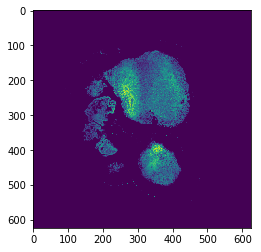

In [12]:
plt.imshow(img)
plt.show()

In [13]:
degrees = 45
scale = (0.8, 1.2)
size = 256

dataset_train = DatasetFolder(os.path.join(working_dir, train_dir),
                              loader=load_tiff_seg,
                              extensions=['.tif'],
                              transform=transforms.Compose([
                                  transforms.ToPILImage(),
                                  transforms.RandomHorizontalFlip(),
                                  transforms.RandomAffine(degrees, 
                                                          scale=scale),
                                  transforms.RandomCrop(size),
                                  transforms.ToTensor()]))
dataset_test = DatasetFolder(os.path.join(working_dir, test_dir),
                             loader=load_tiff_seg,
                             extensions=['.tif'],
                             transform=transforms.ToTensor())

print(dataset_train)
print(dataset_test)

Dataset DatasetFolder
    Number of datapoints: 485
    Root Location: /media/jswaney/SSD EVO 860/organoid_phenotyping/ventricle_segmentation/train_pz
    Transforms (if any): Compose(
                             ToPILImage()
                             RandomHorizontalFlip(p=0.5)
                             RandomAffine(degrees=(-45, 45), scale=(0.8, 1.2))
                             RandomCrop(size=(256, 256), padding=0)
                             ToTensor()
                         )
    Target Transforms (if any): None
Dataset DatasetFolder
    Number of datapoints: 122
    Root Location: /media/jswaney/SSD EVO 860/organoid_phenotyping/ventricle_segmentation/test_pz
    Transforms (if any): ToTensor()
    Target Transforms (if any): None


In [14]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device

device(type='cuda')

In [15]:
batch_size = 1
n_workers = 1 if use_cuda else 0
pin_memory = True if use_cuda else False

dataloader_train = DataLoader(dataset_train, 
                               batch_size, 
                               shuffle=True, 
                               num_workers=n_workers, 
                               pin_memory=pin_memory)

dataloader_test = DataLoader(dataset_test,
                               batch_size, 
                               num_workers=n_workers, 
                               pin_memory=pin_memory)

In [16]:
x, _ = next(iter(dataloader_train))
x.shape, x.dtype, x.max()

(torch.Size([1, 3, 256, 256]), torch.float32, tensor(1.))

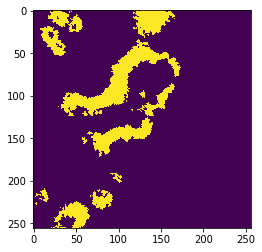

In [17]:
plt.imshow(x.numpy()[0, 1])
plt.show()

In [18]:
model = UNet(n_channels=1, n_classes=1)
model

UNet(
  (inc): inconv(
    (conv): double_conv(
      (conv): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace)
      )
    )
  )
  (down1): down(
    (mpconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): double_conv(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-0

In [19]:
model = model.to(device)

In [20]:
optimizer = Adam(model.parameters(), lr=0.01)

In [21]:
model.train()

UNet(
  (inc): inconv(
    (conv): double_conv(
      (conv): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace)
      )
    )
  )
  (down1): down(
    (mpconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): double_conv(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-0

In [22]:
def train_epoch(model, epoch, dataloader_train, device, optimizer, criterion, log_interval=100):
    model.train()
    n_batch = len(dataloader_train)
    epoch_loss = 0
    count = 0
    for batch_idx, (x, _) in enumerate(dataloader_train):
        img = x[:, 0].unsqueeze(1).to(device)
        seg = x[:, 1].unsqueeze(1).to(device)
        
        if seg.max() > 0:
            weight = torch.tensor([10], dtype=torch.float32).to(device)
        else:
            weight = torch.tensor([1], dtype=torch.float32).to(device)
        
        optimizer.zero_grad()
        output = model(img)
        
        output_flat = output.view(-1)
        seg_flat = seg.view(-1)
        criterion.weight = weight
        loss = criterion(output_flat, seg_flat)
        
        loss.backward()
        optimizer.step()
        
        count += len(x)
        epoch_loss += loss.item()
        ave_loss = epoch_loss / count
        if batch_idx % log_interval == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(x)}/{len(dataloader_train.dataset)} ({100*batch_idx/n_batch:.0f}%)]\tLoss: {ave_loss}')
    

In [23]:
def test_epoch(model, dataloader_test, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for x, _ in dataloader_test:
            img = x[:, 0].unsqueeze(1).to(device)
            seg = x[:, 1].unsqueeze(1).to(device)
            
            output = model(img)
            
            output_flat = output.view(-1)
            seg_flat = seg.view(-1)
            test_loss += criterion(output_flat, seg_flat)
    test_loss /= len(dataloader_test.dataset)
    print(f'Test set: Total loss: {test_loss:.4f}')

In [24]:
criterion = nn.BCELoss()

In [25]:
n_epochs = 200

for epoch in range(n_epochs):
    train_epoch(model, epoch, dataloader_train, device, optimizer, criterion)
    test_epoch(model, dataloader_test, criterion)

/home/jswaney/anaconda3/envs/phathom/lib/python3.7/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/home/jswaney/anaconda3/envs/phathom/lib/python3.7/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 0 [0/485 (0%)]	Loss: 7.110058784484863
Train Epoch: 0 [100/485 (21%)]	Loss: 1.0902533779971966
Train Epoch: 0 [200/485 (41%)]	Loss: 0.9731279442698431
Train Epoch: 0 [300/485 (62%)]	Loss: 0.8874099421611928
Train Epoch: 0 [400/485 (82%)]	Loss: 0.8490107688957598
Test set: Total loss: 0.0537
Train Epoch: 1 [0/485 (0%)]	Loss: 0.5648212432861328
Train Epoch: 1 [100/485 (21%)]	Loss: 0.6896176296286285
Train Epoch: 1 [200/485 (41%)]	Loss: 0.6549522218720719
Train Epoch: 1 [300/485 (62%)]	Loss: 0.6763585833724328
Train Epoch: 1 [400/485 (82%)]	Loss: 0.6997815178767627
Test set: Total loss: 0.9756
Train Epoch: 2 [0/485 (0%)]	Loss: 0.04479869455099106
Train Epoch: 2 [100/485 (21%)]	Loss: 0.605359316513053
Train Epoch: 2 [200/485 (41%)]	Loss: 0.654182317678293
Train Epoch: 2 [300/485 (62%)]	Loss: 0.6636336801234831
Train Epoch: 2 [400/485 (82%)]	Loss: 0.6301653602449665
Test set: Total loss: 0.3480
Train Epoch: 3 [0/485 (0%)]	Loss: 0.009719116613268852
Train Epoch: 3 [100/485 (21%)

Train Epoch: 26 [300/485 (62%)]	Loss: 0.2954180331472764
Train Epoch: 26 [400/485 (82%)]	Loss: 0.30653545302760576
Test set: Total loss: 0.0207
Train Epoch: 27 [0/485 (0%)]	Loss: 0.27704986929893494
Train Epoch: 27 [100/485 (21%)]	Loss: 0.32840754071665934
Train Epoch: 27 [200/485 (41%)]	Loss: 0.35284349402902976
Train Epoch: 27 [300/485 (62%)]	Loss: 0.3513426117759299
Train Epoch: 27 [400/485 (82%)]	Loss: 0.3469427528522246
Test set: Total loss: 0.0191
Train Epoch: 28 [0/485 (0%)]	Loss: 0.005143890623003244
Train Epoch: 28 [100/485 (21%)]	Loss: 0.31986710485864817
Train Epoch: 28 [200/485 (41%)]	Loss: 0.3037297739296563
Train Epoch: 28 [300/485 (62%)]	Loss: 0.3088495661375243
Train Epoch: 28 [400/485 (82%)]	Loss: 0.3176715803249561
Test set: Total loss: 0.0213
Train Epoch: 29 [0/485 (0%)]	Loss: 0.00023622522712685168
Train Epoch: 29 [100/485 (21%)]	Loss: 0.2885800917618974
Train Epoch: 29 [200/485 (41%)]	Loss: 0.32481303894849983
Train Epoch: 29 [300/485 (62%)]	Loss: 0.356187351693921

Train Epoch: 52 [400/485 (82%)]	Loss: 0.274109258612474
Test set: Total loss: 0.1969
Train Epoch: 53 [0/485 (0%)]	Loss: 0.4584274888038635
Train Epoch: 53 [100/485 (21%)]	Loss: 0.2799229423575219
Train Epoch: 53 [200/485 (41%)]	Loss: 0.28685526380972287
Train Epoch: 53 [300/485 (62%)]	Loss: 0.28378231393002584
Train Epoch: 53 [400/485 (82%)]	Loss: 0.2866228565756063
Test set: Total loss: 0.0199
Train Epoch: 54 [0/485 (0%)]	Loss: 0.3329544961452484
Train Epoch: 54 [100/485 (21%)]	Loss: 0.2614106420361789
Train Epoch: 54 [200/485 (41%)]	Loss: 0.2591818715871395
Train Epoch: 54 [300/485 (62%)]	Loss: 0.26339573794585974
Train Epoch: 54 [400/485 (82%)]	Loss: 0.2571764543961654
Test set: Total loss: 0.1818
Train Epoch: 55 [0/485 (0%)]	Loss: 0.7792612314224243
Train Epoch: 55 [100/485 (21%)]	Loss: 0.27758640691917935
Train Epoch: 55 [200/485 (41%)]	Loss: 0.2796266006265597
Train Epoch: 55 [300/485 (62%)]	Loss: 0.2595345230859122
Train Epoch: 55 [400/485 (82%)]	Loss: 0.25041996157895646
Test s

Test set: Total loss: 0.1738
Train Epoch: 79 [0/485 (0%)]	Loss: 0.18676692247390747
Train Epoch: 79 [100/485 (21%)]	Loss: 0.26153087804549174
Train Epoch: 79 [200/485 (41%)]	Loss: 0.24419606910904085
Train Epoch: 79 [300/485 (62%)]	Loss: 0.23498605820918103
Train Epoch: 79 [400/485 (82%)]	Loss: 0.22901138123458628
Test set: Total loss: 0.2134
Train Epoch: 80 [0/485 (0%)]	Loss: 0.19483914971351624
Train Epoch: 80 [100/485 (21%)]	Loss: 0.20210650002821123
Train Epoch: 80 [200/485 (41%)]	Loss: 0.22551907587281467
Train Epoch: 80 [300/485 (62%)]	Loss: 0.22162599977788502
Train Epoch: 80 [400/485 (82%)]	Loss: 0.23268914377105257
Test set: Total loss: 0.1892
Train Epoch: 81 [0/485 (0%)]	Loss: 0.3941431939601898
Train Epoch: 81 [100/485 (21%)]	Loss: 0.21312760822331597
Train Epoch: 81 [200/485 (41%)]	Loss: 0.2565049088419693
Train Epoch: 81 [300/485 (62%)]	Loss: 0.24497599255441538
Train Epoch: 81 [400/485 (82%)]	Loss: 0.2468912857416444
Test set: Total loss: 0.1588
Train Epoch: 82 [0/485 (0%

Test set: Total loss: 0.1875
Train Epoch: 105 [0/485 (0%)]	Loss: 0.2780381441116333
Train Epoch: 105 [100/485 (21%)]	Loss: 0.2343338751470763
Train Epoch: 105 [200/485 (41%)]	Loss: 0.2214927362773059
Train Epoch: 105 [300/485 (62%)]	Loss: 0.203486107051434
Train Epoch: 105 [400/485 (82%)]	Loss: 0.21173556107472827
Test set: Total loss: 0.2230
Train Epoch: 106 [0/485 (0%)]	Loss: 0.43037062883377075
Train Epoch: 106 [100/485 (21%)]	Loss: 0.20512494693018496
Train Epoch: 106 [200/485 (41%)]	Loss: 0.19610102734762436
Train Epoch: 106 [300/485 (62%)]	Loss: 0.19772300059221637
Train Epoch: 106 [400/485 (82%)]	Loss: 0.19212042144612726
Test set: Total loss: 0.4743
Train Epoch: 107 [0/485 (0%)]	Loss: 0.6693946123123169
Train Epoch: 107 [100/485 (21%)]	Loss: 0.23432785447630522
Train Epoch: 107 [200/485 (41%)]	Loss: 0.22358097565232476
Train Epoch: 107 [300/485 (62%)]	Loss: 0.2235665697359924
Train Epoch: 107 [400/485 (82%)]	Loss: 0.2274597390594125
Test set: Total loss: 0.1757
Train Epoch: 108

Train Epoch: 130 [300/485 (62%)]	Loss: 0.21993386596554396
Train Epoch: 130 [400/485 (82%)]	Loss: 0.2155934870430392
Test set: Total loss: 0.1512
Train Epoch: 131 [0/485 (0%)]	Loss: 0.3973899483680725
Train Epoch: 131 [100/485 (21%)]	Loss: 0.24293121864066772
Train Epoch: 131 [200/485 (41%)]	Loss: 0.2198814275933325
Train Epoch: 131 [300/485 (62%)]	Loss: 0.2109639221571735
Train Epoch: 131 [400/485 (82%)]	Loss: 0.21243213496188815
Test set: Total loss: 0.1473
Train Epoch: 132 [0/485 (0%)]	Loss: 0.1282653510570526
Train Epoch: 132 [100/485 (21%)]	Loss: 0.1915399200110556
Train Epoch: 132 [200/485 (41%)]	Loss: 0.21829705380229658
Train Epoch: 132 [300/485 (62%)]	Loss: 0.21876481218880653
Train Epoch: 132 [400/485 (82%)]	Loss: 0.21640551393896604
Test set: Total loss: 0.1323
Train Epoch: 133 [0/485 (0%)]	Loss: 0.273540735244751
Train Epoch: 133 [100/485 (21%)]	Loss: 0.17753933657853183
Train Epoch: 133 [200/485 (41%)]	Loss: 0.18118760689586494
Train Epoch: 133 [300/485 (62%)]	Loss: 0.1920

Train Epoch: 156 [100/485 (21%)]	Loss: 0.1520536351738136
Train Epoch: 156 [200/485 (41%)]	Loss: 0.1848894949031811
Train Epoch: 156 [300/485 (62%)]	Loss: 0.1952283965750826
Train Epoch: 156 [400/485 (82%)]	Loss: 0.19997511041576263
Test set: Total loss: 0.1500
Train Epoch: 157 [0/485 (0%)]	Loss: 0.0006367142195813358
Train Epoch: 157 [100/485 (21%)]	Loss: 0.2038606994847259
Train Epoch: 157 [200/485 (41%)]	Loss: 0.1947105888339104
Train Epoch: 157 [300/485 (62%)]	Loss: 0.19504566001265355
Train Epoch: 157 [400/485 (82%)]	Loss: 0.2003906652869613
Test set: Total loss: 0.1316
Train Epoch: 158 [0/485 (0%)]	Loss: 0.3948659300804138
Train Epoch: 158 [100/485 (21%)]	Loss: 0.16672696206166782
Train Epoch: 158 [200/485 (41%)]	Loss: 0.18248206053516497
Train Epoch: 158 [300/485 (62%)]	Loss: 0.18397818486033563
Train Epoch: 158 [400/485 (82%)]	Loss: 0.1819659022369597
Test set: Total loss: 0.1578
Train Epoch: 159 [0/485 (0%)]	Loss: 0.2450590580701828
Train Epoch: 159 [100/485 (21%)]	Loss: 0.178

Test set: Total loss: 0.1354
Train Epoch: 182 [0/485 (0%)]	Loss: 0.0004903036169707775
Train Epoch: 182 [100/485 (21%)]	Loss: 0.20081068011347838
Train Epoch: 182 [200/485 (41%)]	Loss: 0.18988338444415406
Train Epoch: 182 [300/485 (62%)]	Loss: 0.1832761695255923
Train Epoch: 182 [400/485 (82%)]	Loss: 0.17585274122274697
Test set: Total loss: 0.1386
Train Epoch: 183 [0/485 (0%)]	Loss: 0.08245483785867691
Train Epoch: 183 [100/485 (21%)]	Loss: 0.19459527664515341
Train Epoch: 183 [200/485 (41%)]	Loss: 0.1856838452680568
Train Epoch: 183 [300/485 (62%)]	Loss: 0.18896390318846396
Train Epoch: 183 [400/485 (82%)]	Loss: 0.1834889877637642
Test set: Total loss: 0.1527
Train Epoch: 184 [0/485 (0%)]	Loss: 0.13893035054206848
Train Epoch: 184 [100/485 (21%)]	Loss: 0.18517053459975902
Train Epoch: 184 [200/485 (41%)]	Loss: 0.19456994820070259
Train Epoch: 184 [300/485 (62%)]	Loss: 0.19140029262747132
Train Epoch: 184 [400/485 (82%)]	Loss: 0.18772588983651622
Test set: Total loss: 0.0152
Train Epo

In [26]:
x, _ = next(iter(dataloader_train))
img = x[:, 0].unsqueeze(1).to(device)
seg = x[:, 1].unsqueeze(1).to(device)
output = model(img)
output.shape

torch.Size([1, 1, 256, 256])

In [27]:
img = img.detach().cpu().numpy()
seg = seg.detach().cpu().numpy()
output = output.detach().cpu().numpy()
img.shape, output.shape

((1, 1, 256, 256), (1, 1, 256, 256))

In [28]:
img = img[0, 0]
seg = seg[0, 0]
output = output[0, 0]
img.shape, output.shape

((256, 256), (256, 256))

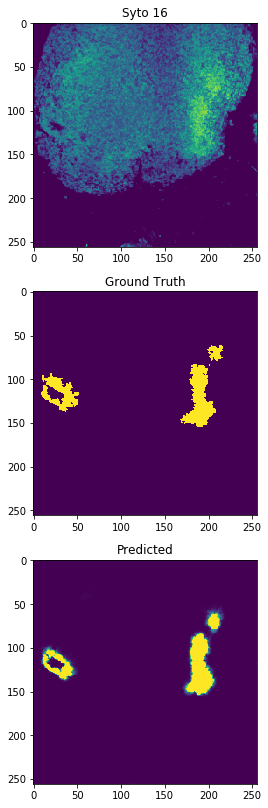

In [29]:
plt.figure(figsize=(6, 14))
plt.subplot(311)
plt.imshow(img, clim=[0, 1])
plt.title('Syto 16')
plt.subplot(312)
plt.imshow(seg, clim=[0, 1])
plt.title('Ground Truth')
plt.subplot(313)
plt.imshow(output, clim=[0, 0.3])
plt.title('Predicted')
plt.show()

In [30]:
torch.save(model.state_dict(), os.path.join(working_dir, 'unet_pz_200.pt'))